In [8]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from tyssue.generation import generate_ring
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.draw.plt_draw import sheet_view

from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.segmentation.segment2D import normalize_scale
from tyssue_taylor.adjusters.adjust_annular import (set_init_point,
                                                    prepare_tensions,
                                                    adjust_parameters,
                                                    adjust_tensions)
from tyssue_taylor.models.display import (print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side

In [2]:
def create_organo(nb_cells, r_in, r_out, seed=None, rot=None, geom=geom):
    organo = generate_ring(nb_cells, r_in, r_out)
    Nf = organo.Nf
    geom.update_all(organo)
    alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))
    specs = {
        'face': {
            'is_alive': 1,
            'prefered_area': organo.face_df.area,
            'area_elasticity': 1., },
        'edge': {
            'ux': 0.,
            'uy': 0.,
            'uz': 0.,
            'line_tension': 0.1,
            'is_active': 1
            },
        'vert': {
            'adhesion_strength': 0.,
            'x_ecm': 0.,
            'y_ecm': 0.,
            'is_active': 1
            },
        'settings': {
            'lumen_elasticity': 0.1,
            'lumen_prefered_vol': organo.settings['lumen_volume'],
            'lumen_volume': organo.settings['lumen_volume']
            }
        }
    organo.update_specs(specs, reset=True)
    normalize_scale(organo, geom, refer='edges')
    geom.update_all(organo)
    if seed is not None:
        symetric_tensions = set_init_point(organo.settings['R_in'],
                                           organo.settings['R_out'],
                                           organo.Nf, alpha)
        sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf,
                                        endpoint=False)))**2
        organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
        organo.edge_df.line_tension = prepare_tensions(organo,
                                                       symetric_tensions)
        organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul*np.random.normal(
            1.0, 0.05, organo.Nf)
        geom.update_all(organo)
    if rot is not None:
        organo.vert_df.loc[:, 'x'] = (organo.vert_df.x.copy() * np.cos(rot) -
                                      organo.vert_df.y.copy() * np.sin(rot))
        print('rotated x',
              organo.vert_df.x.copy() * np.cos(rot) -
              organo.vert_df.y.copy() * np.sin(rot))
        organo.vert_df.loc[:, 'y'] = (organo.vert_df.x.copy() * np.sin(rot) +
                                      organo.vert_df.y.copy() * np.cos(rot))
        print('rotated y',
              organo.vert_df.x.copy() * np.sin(rot) +
              organo.vert_df.y.copy() * np.cos(rot))
        geom.update_all(organo)
    organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]
    organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01
    new_tensions = organo.edge_df.line_tension
    organo.edge_df.loc[:, 'line_tension'] = new_tensions
    return organo

Reseting datasets values with new specs


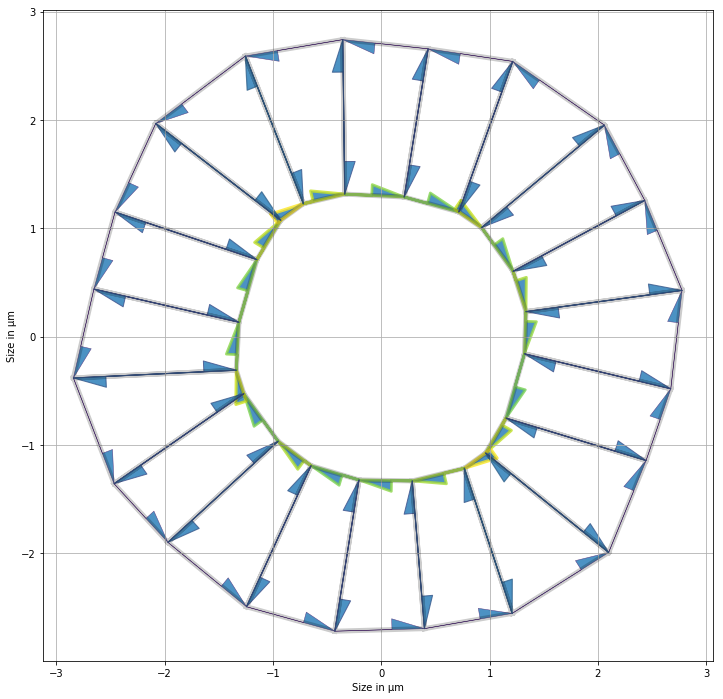

In [3]:
nf, r_in, r_out = (20, 1, 2)
seed = 1
organo = create_organo(nf, r_in, r_out)

organo.edge_df.loc[organo.apical_edges, 'line_tension'] = [
    0.101, 0.115, 0.126, 0.110, 0.105,
    0.102, 0.112, 0.102, 0.118, 0.105,
    0.104, 0.115, 0.127, 0.116, 0.106,
    0.103, 0.117, 0.105, 0.111, 0.107
]

organo.edge_df.loc[organo.basal_edges, 'line_tension'] = [
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01,
    0.01, 0.011, 0.012, 0.011, 0.01,
    0.01, 0.011, 0.01, 0.011, 0.01
]

organo.edge_df.loc[organo.lateral_edges, 'line_tension'] = np.array([
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03,
    0.03, 0.035, 0.04, 0.035, 0.03,
    0.03, 0.035, 0.03, 0.035, 0.03
])

organo.face_df.loc[:, 'prefered_area'] = np.array([
    0.08, 0.07, 0.08, 0.09, 0.09,
    0.10, 0.09, 0.08, 0.09, 0.09,
    0.10, 0.11, 0.10, 0.11, 0.12,
    0.11, 0.10, 0.09, 0.08, 0.09
]) + organo.face_df.area

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)
print_tensions(organo, organo)

Using a straightforward initial point supposing that line tensions are proportional to length

In [4]:
def length_init(organo):
    organo.get_extra_indices()
    normalizing_factor = 0.1/organo.edge_df.length[organo.sgle_edges].mean()
    dist_to_max = organo.edge_df.length.max() - organo.edge_df.length[organo.sgle_edges]
    res = dist_to_max * normalizing_factor
    return res

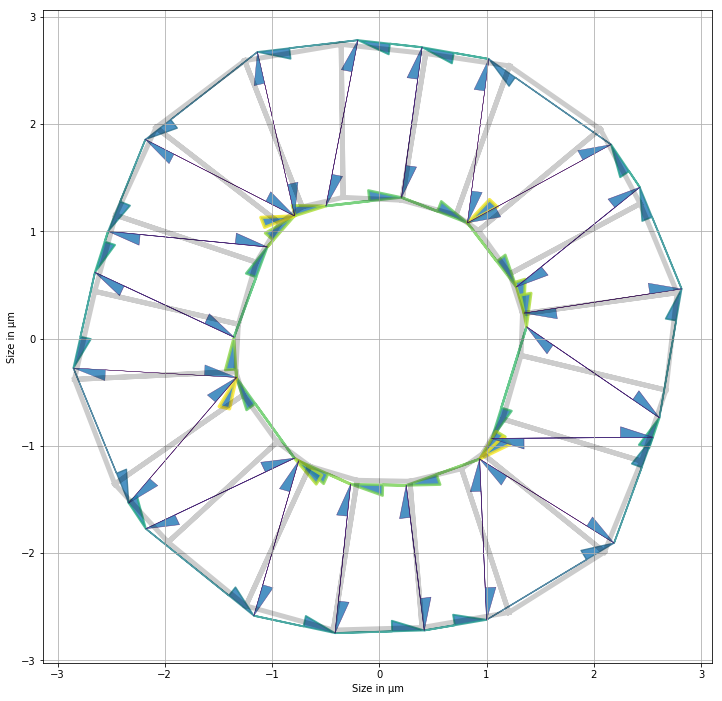

In [5]:
img_organo = organo.copy()
img_organo.edge_df.loc[:, 'line_tension'] = prepare_tensions(img_organo, length_init(organo))
Solver.find_energy_min(img_organo, geom, model)
print_tensions(img_organo, organo)

In [6]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1000, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

print_file = 'test_file.txt'

In [23]:
res_tensions_only = adjust_tensions(organo, length_init(organo),
                                    {'dic': {}, 'weight': 0}, energy_min_opt=energy_opt,
                                    iprint_file=print_file, **lm_opt)

`ftol` termination condition is satisfied.
Function evaluations 249, initial cost 3.2343e-01, final cost 1.4346e-01, first-order optimality 3.00e+00.


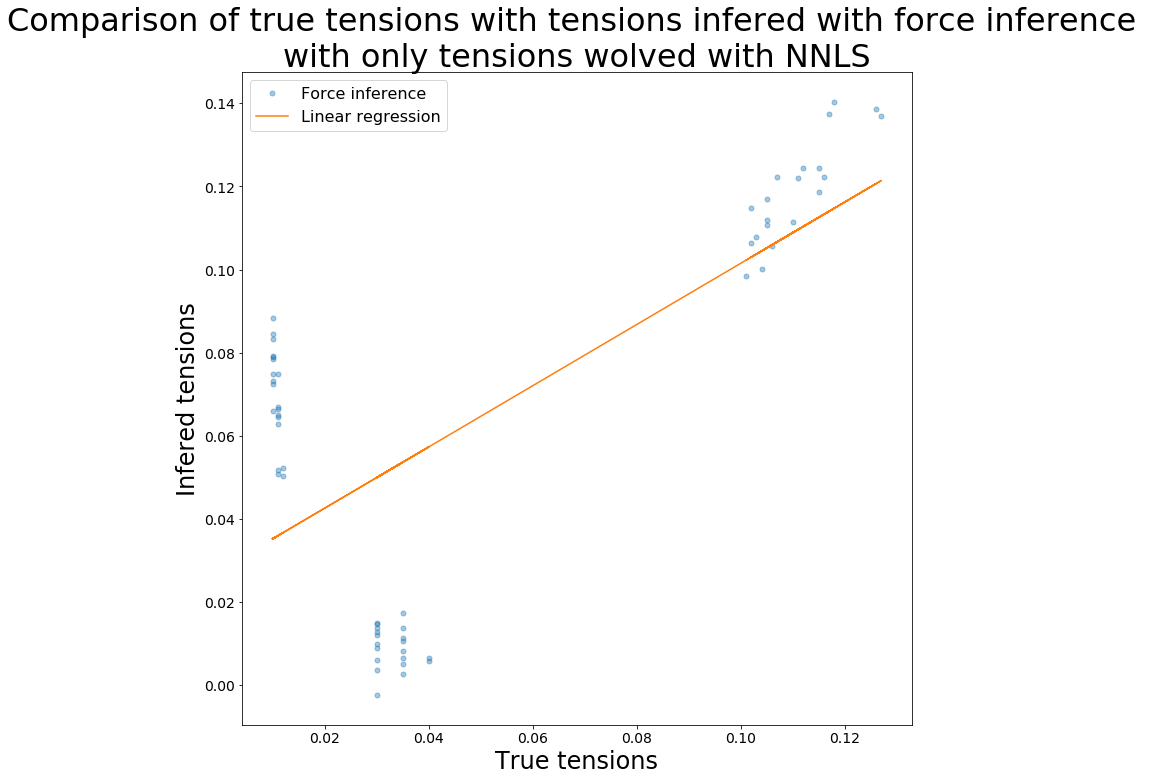

R value : 0.6907519401596466 
Standard error : 0.028735343148626857


In [24]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  res_tensions_only.x[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [11]:
img_organo = organo.copy()
img_organo.edge_df.loc[:, 'line_tension'] = prepare_tensions(img_organo, res_tensions_only.x[:3*organo.Nf])
Solver.find_energy_min(img_organo, geom, model)
print_tensions(img_organo, organo)

NameError: name 'res_tensions_only' is not defined

In [7]:
res_tensions_only_psqp = adjust_tensions(organo, list(length_init(organo)),
                                         {'dic': {}, 'weight': 0}, energy_min_opt=energy_opt,
                                         initial_min_opt=lm_opt,
                                         iprint_file=print_file, **psqp_opt)

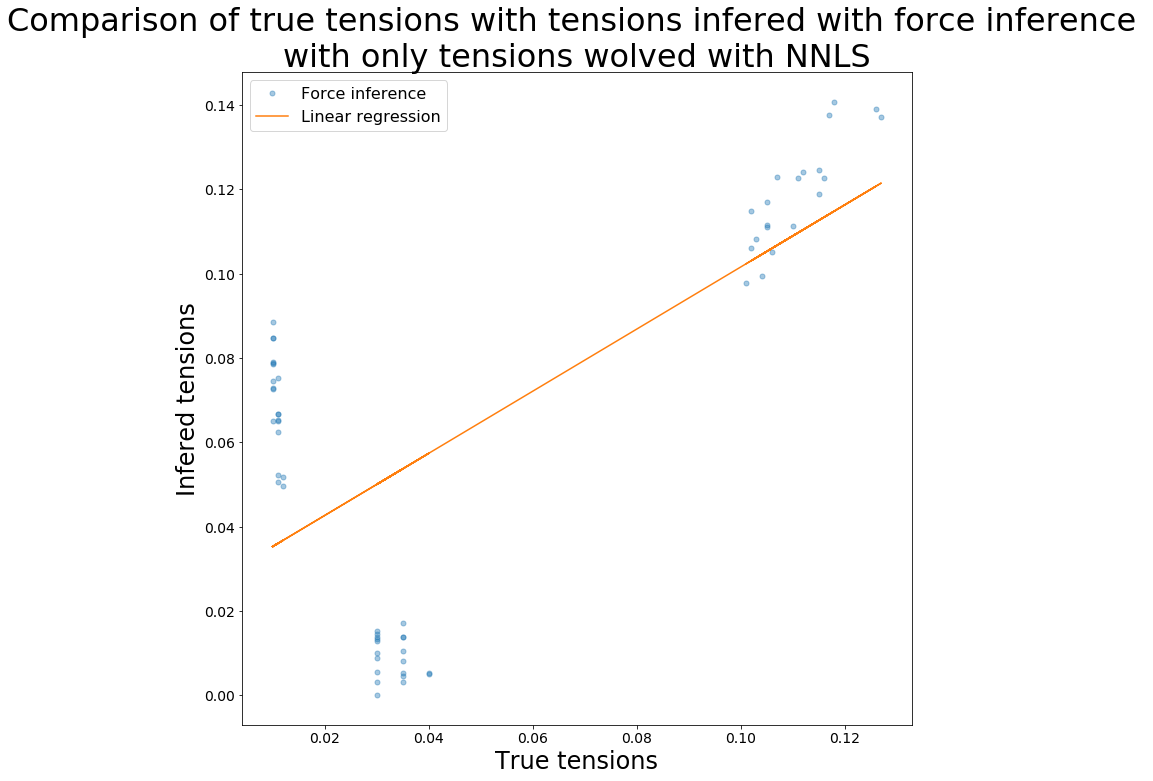

R value : 0.6902435219438465 
Standard error : 0.02877363416414886


In [10]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  res_tensions_only_psqp['x'][:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [7]:
from scipy.optimize import nnls
initial_guess = infer_forces(organo, method='LINALG', sup_param='areas')

In [9]:
matrix = _coef_matrix(organo, sup_param='areas')
matrix[1]+matrix[2]+matrix[3]+matrix[4]+matrix[5]

array([ 0.27517678,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.95833594,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.95697717,  0.77794151,  0.31318774,  0.08226434,
       -0.15817158,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.49274393,  0.58543739,  0.35173839,  0.128685  ,  0.00742139,
       -0.76407396, -0.        , -0.        , -0.        , -0.  

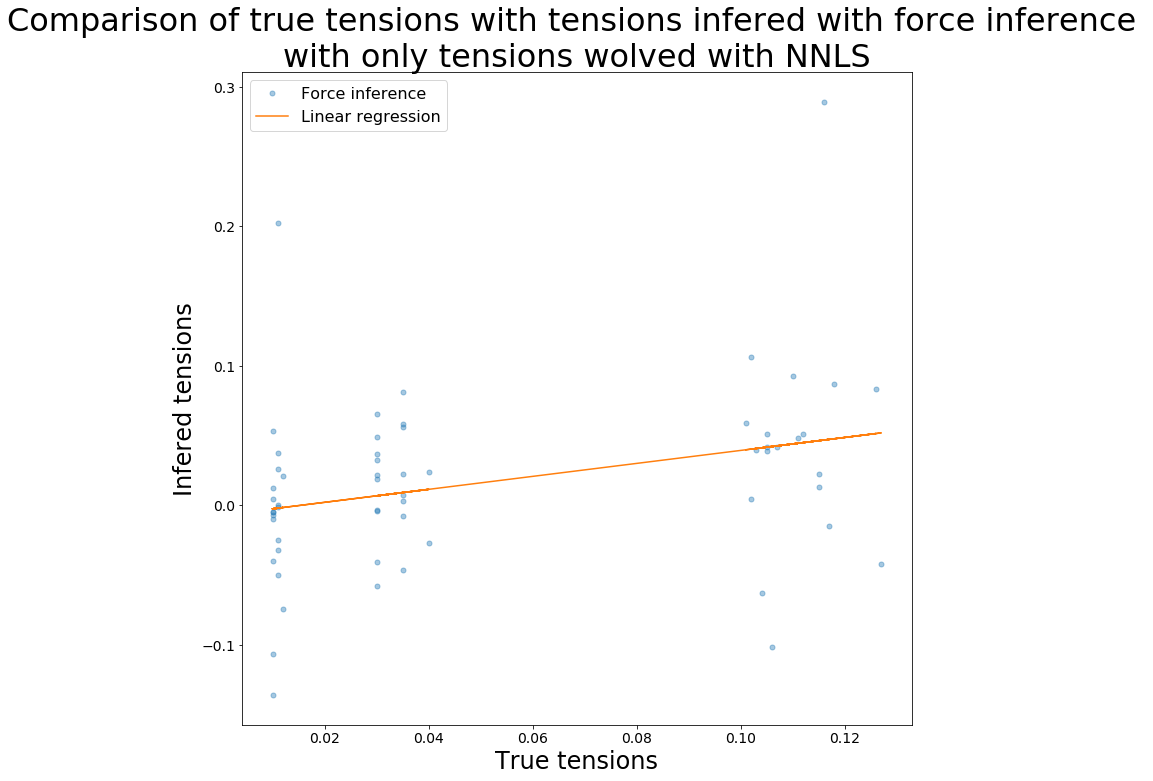

R value : 0.30657150116596094 
Standard error : 0.05379804680759521


In [9]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  initial_guess['tensions'],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

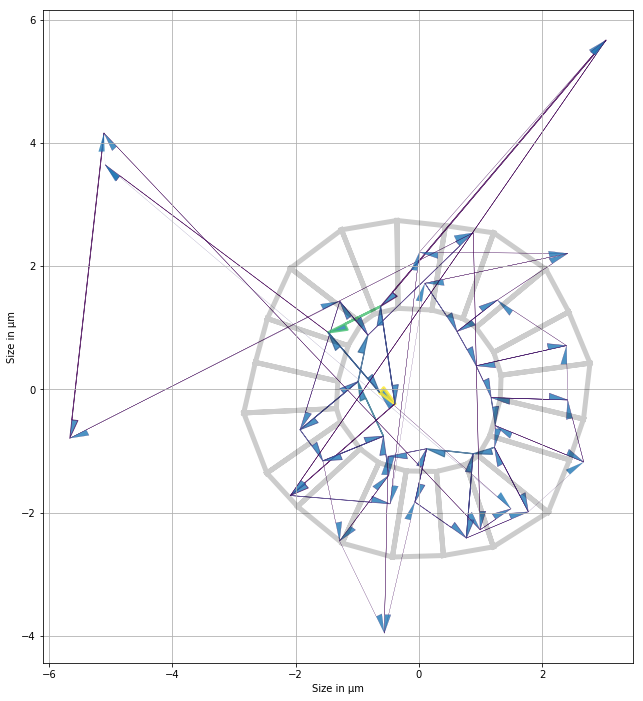

In [10]:
img_organo = organo.copy()
img_organo.edge_df.loc[:, 'line_tension'] = prepare_tensions(img_organo, initial_guess['tensions'])
Solver.find_energy_min(img_organo, geom, model)
print_tensions(img_organo, organo)

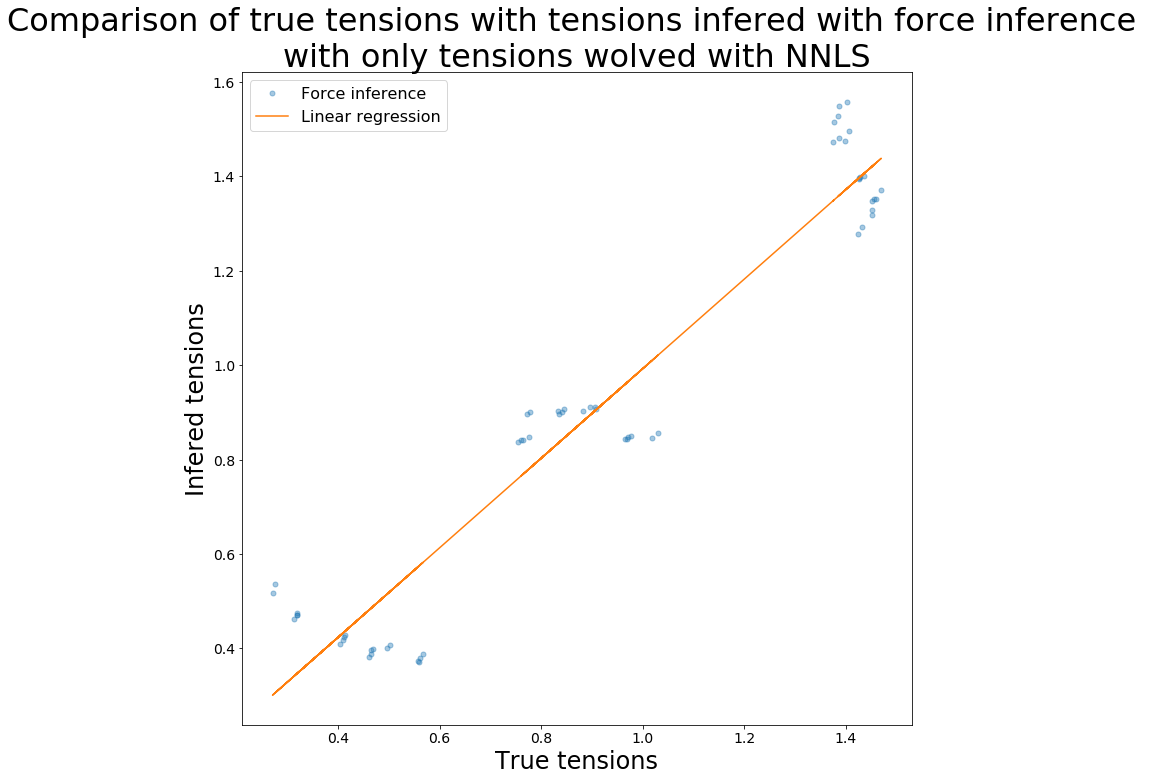

R value : 0.9590691454265886 
Standard error : 0.1003578823913962


In [67]:
rendering_results(organo, organo.edge_df.length[:3*organo.Nf],
                  img_organo.edge_df.length[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

In [10]:
opt_initial_guess = np.concatenate((prepare_tensions(organo, initial_guess['tensions']),
                                    initial_guess['areas']))
res_areas_and_tensions = adjust_parameters(organo,
                                           prepare_tensions(organo, initial_guess['tensions']),
                                           {'dic': {}, 'weight': 0}, energy_min_opt=energy_opt,
                                           parameters=[('edge', 'line_tension')],
                                           iprint_file=print_file, **lm_opt)

`xtol` termination condition is satisfied.
Function evaluations 415, initial cost 5.2496e+00, final cost 2.0992e+00, first-order optimality 6.94e+03.


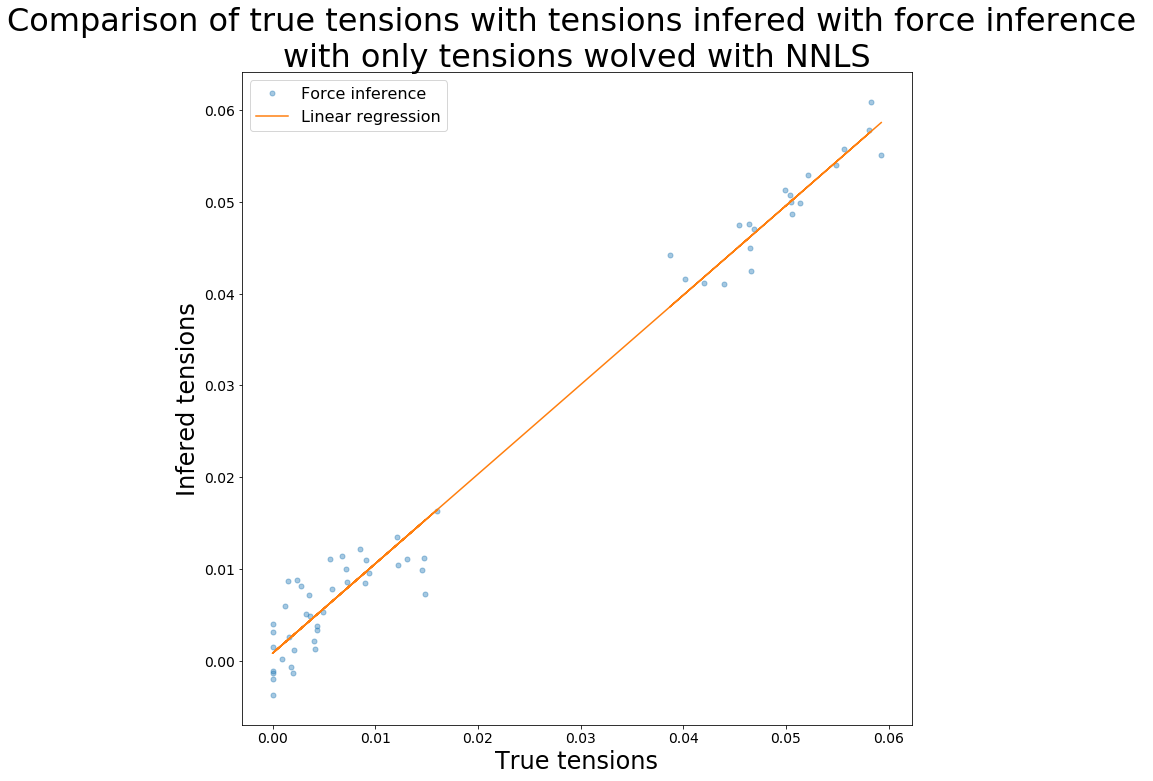

R value : 0.9904700978459685 
Standard error : 0.002512897160668817


In [16]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  res_areas_and_tensions.x[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

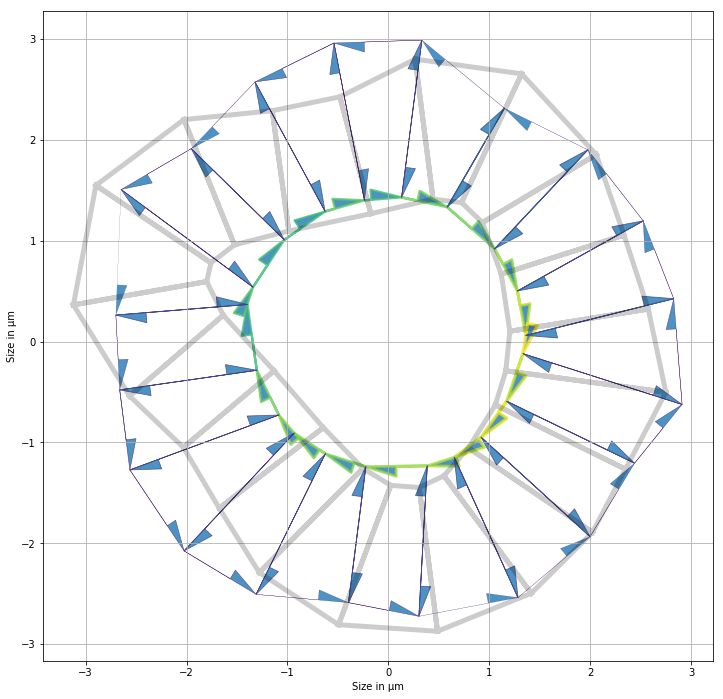

In [19]:
params_organo = organo.copy()
params_organo.edge_df.loc[:, 'line_tension'] = prepare_tensions(params_organo, res_areas_and_tensions.x[:3*organo.Nf])
Solver.find_energy_min(params_organo, geom, model)
print_tensions(params_organo, organo)

In [11]:
res_tensions_only = adjust_tensions(organo, initial_guess['tensions'],
                                    {'dic': {}, 'weight': 0}, energy_min_opt=energy_opt,
                                    iprint_file=print_file, **lm_opt)

`xtol` termination condition is satisfied.
Function evaluations 435, initial cost 5.2496e+00, final cost 1.9453e+00, first-order optimality 2.90e+03.


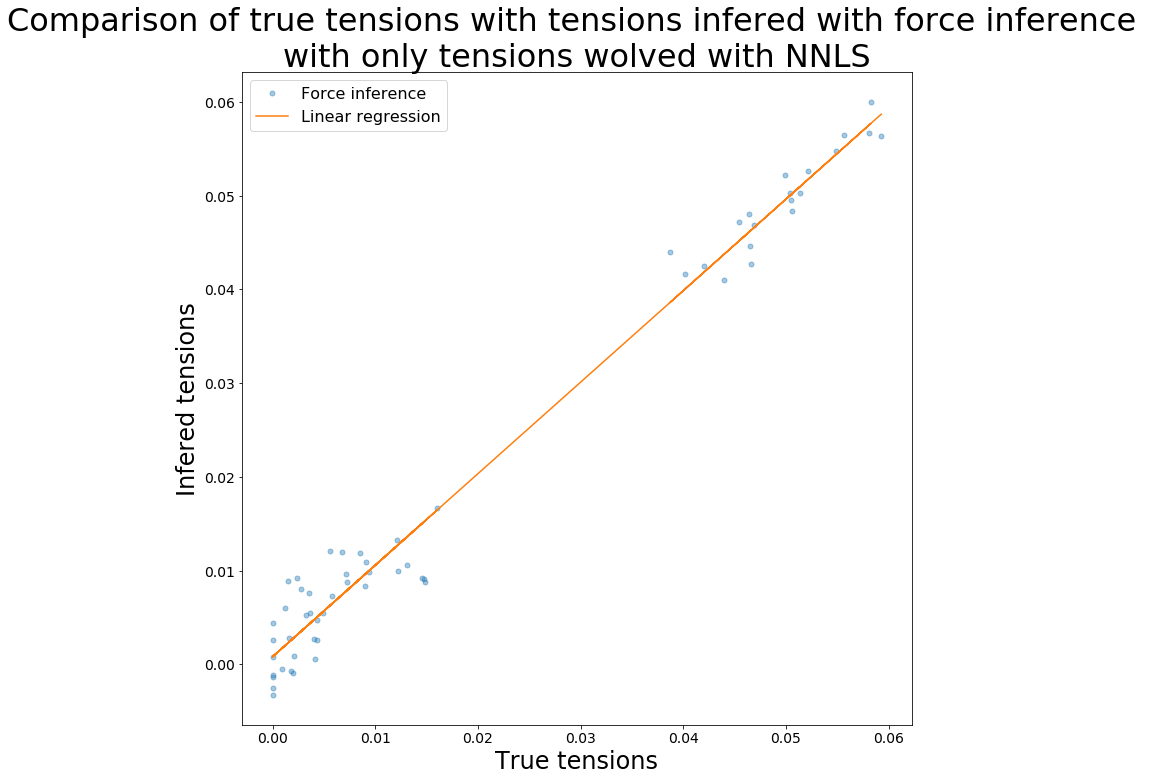

R value : 0.9899215765432364 
Standard error : 0.0025861429529405993


In [17]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  res_tensions_only.x[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

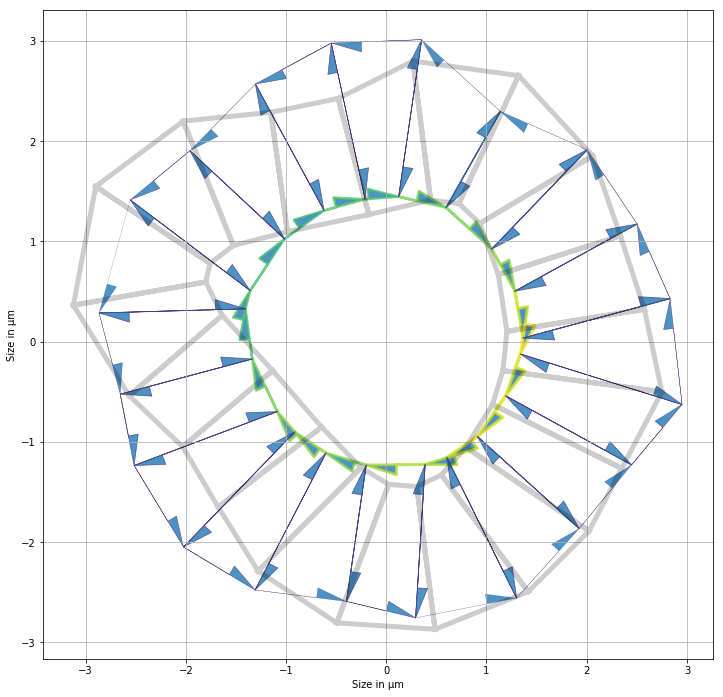

In [20]:
tensions_adjust_organo = organo.copy()
tensions_adjust_organo.edge_df.loc[:, 'line_tension'] = prepare_tensions(tensions_adjust_organo,
                                                                         res_tensions_only.x[:3*organo.Nf])
Solver.find_energy_min(tensions_adjust_organo, geom, model)
print_tensions(tensions_adjust_organo, organo)

In [12]:
from scipy.optimize import nnls
matrix = _coef_matrix(organo, sup_param='areas')
matrix[:, 3*organo.Nf:] *= -1
constant = _right_side(organo, matrix)
last_line_c = constant[-1]
constant[-1] = organo.edge_df.loc[organo.apical_edges, 'line_tension'].sum()
constant = np.concatenate((constant, [organo.edge_df.loc[organo.basal_edges, 'line_tension'].sum(),
                                      organo.edge_df.loc[organo.lateral_edges[:organo.Nf], 'line_tension'].sum()]))
matrix[-1] = np.concatenate((np.ones(organo.Nf), np.zeros(matrix.shape[1]-organo.Nf)))
matrix = np.vstack((matrix,
                    np.concatenate((np.zeros(organo.Nf),
                                    np.ones(organo.Nf),
                                    np.zeros(matrix.shape[1]-2*organo.Nf))),
                    np.concatenate((np.zeros(2*organo.Nf),
                                    np.ones(organo.Nf),
                                    np.zeros(matrix.shape[1]-3*organo.Nf)))))
initial_guess = nnls(matrix, constant)[0][:organo.Nf*3]

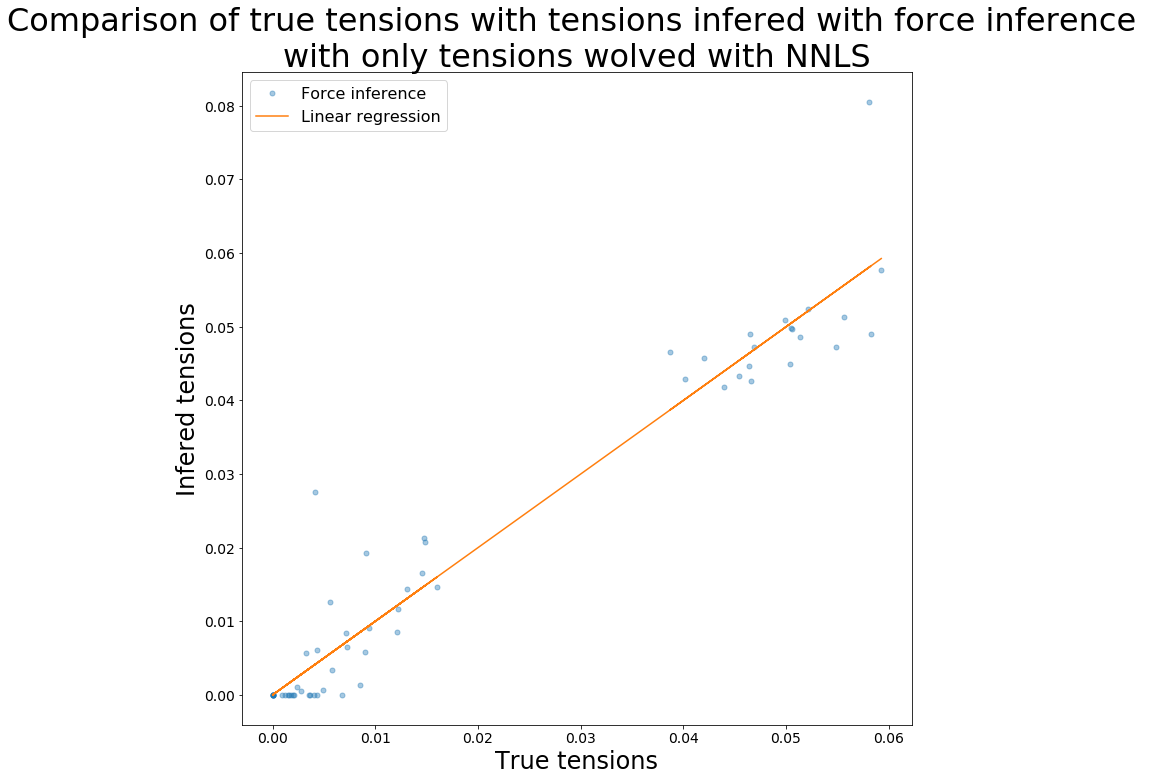

R value : 0.967709046414535 
Standard error : 0.004817231798201178


In [13]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  initial_guess,
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

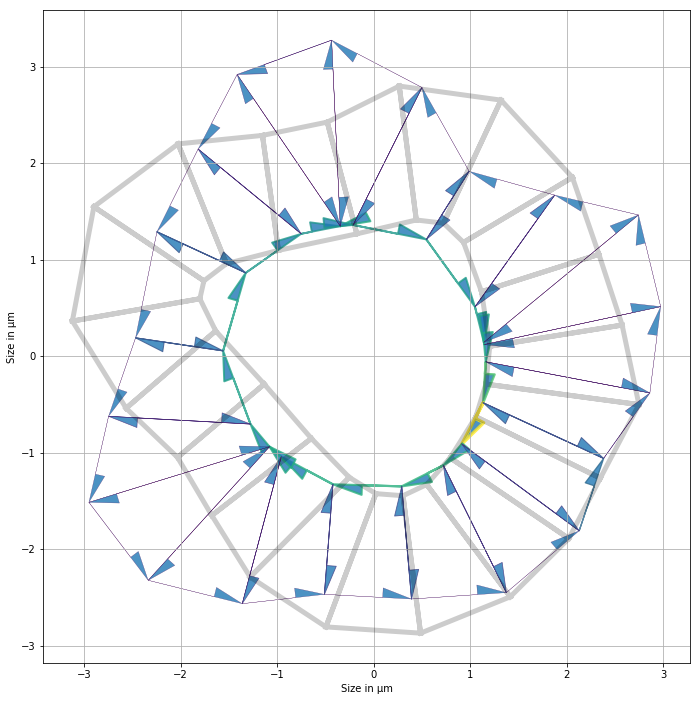

In [14]:
img_organo = organo.copy()
img_organo.edge_df.loc[:, 'line_tension'] = prepare_tensions(img_organo, initial_guess)
Solver.find_energy_min(img_organo, geom, model)
print_tensions(img_organo, organo)